**<center><font color='#023F7C' size="6.5">AI Explainability course</font>** <br>
<font color=#023F7C size=4>**Hi!ckathon #5 - AI & Sustainability**</font> <br>
<font color=#023F7C size=2> 6:15PM-6:45PM </font> <br>

</center>

<img src = https://www.hi-paris.fr/wp-content/uploads/2020/09/logo-hi-paris-retina.png width = "300" height = "200" >

<font color="#023F7C">**Author**:</font> Laurène DAVID, Machine Learning Research Engineer @ Hi! PARIS <br>

All of the Data Science courses are available in the <font color=#023F7C><b> Hickathon5 git repository</b></font>:  https://github.com/hi-paris/Hickathon5 <br>
If you are enjoying these courses, please don't hesitate to add a star ⭐ to this repository. The team would greatly appreciate it !

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

# **1. Explainable AI**

**Explainable AI** refers to the ability of a Machine Learning model to deliver human understandable explanations for the predictions made by a machine. It's goal is to bridge the gap between human understanding and AI models by making the decision-making process interpretable and transparent.

Understanding the inner workings of a model helps build trust among users
and stakeholders, as well as increase acceptance. This is crucial, especially in sensitive domains like healthcare, finance, and criminal justice with ethical concerns and regulation requirements.

<br>

<img src = https://www.darpa.mil/ddm_gallery/xai-figure2-inline-graphic.png width = "600" height = "350" >

In practice, Explainable AI means being able to **understand which feature used by a model during training had the most impact on the final predictions** and how to **quantify this impact**.

Most machine learning models have their own method to quantify feature importance. Here is a recap of these methods.
- **Linear Regression, Logistic Regression, SVM** (Linear models): the absolute value of the estimated coefficients can be seen as a measure of feature importance
- **Decision Tree, Random Forest, XGBoost** (Tree models): Impurity-based methods for explainability



## Explainability vs Performance
It is important to note that not every model is equally explainable. <br> There is often a trade-off between explainability and model performance.

<img src = https://www.researchgate.net/publication/332209054/figure/fig1/AS:743991452631045@1554392793570/Accuracy-vs-Explainability-of-the-main-machine-learning-algorithms.ppm width = "600" height = "400" >

Neural networks are considered to be state-of-the-art models for many tasks in Machine Learning but they are the least explainable, understandable to humans. They are often categorized as "Black-Box" models since it can be very difficult to understand their decision making process.


## Model-specific explainability (Random Forest)

Here is a reminder of a model-specific explainability method using a Random Forest model. <br>


`RandomForestClassifier` has an attribute called `.feature_importances_` which uses **impurity-based feature importance** to provide explainability. Impurity-based explainability measures the importance of a feature by looking at the decrease in impurity that a feature introduces when used for splitting nodes in the tree.

<br>

<img src = https://miro.medium.com/v2/resize:fit:781/1*fGX0_gacojVa6-njlCrWZw.png width = "500" height = "300" >

These methods are specific to Machine Learning models that uses trees, such as Decision Tree, Random Forest and Boosting.

In [4]:
path_data = "..\Machine_Learning"
data_class_train = pd.read_csv(os.path.join(path_data,"CoursML_Classification_train.csv"))
data_class_test = pd.read_csv(os.path.join(path_data, "CoursML_Classification_test.csv"))

In [5]:
from sklearn.ensemble import RandomForestClassifier

# Get train-test split with X and y
X_train, y_train = data_class_train.drop(columns=["genre"]), data_class_train["genre"]
X_test, y_test = data_class_test.drop(columns=["genre"]), data_class_test["genre"]

# Train a random forest model
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [6]:
from sklearn.metrics import accuracy_score

# Predict values for X_test
y_pred_rf = rf.predict(X_test)

# Compute the predictions accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_rf)
print("Model accuracy: ", accuracy)

Model accuracy:  0.8626728110599078


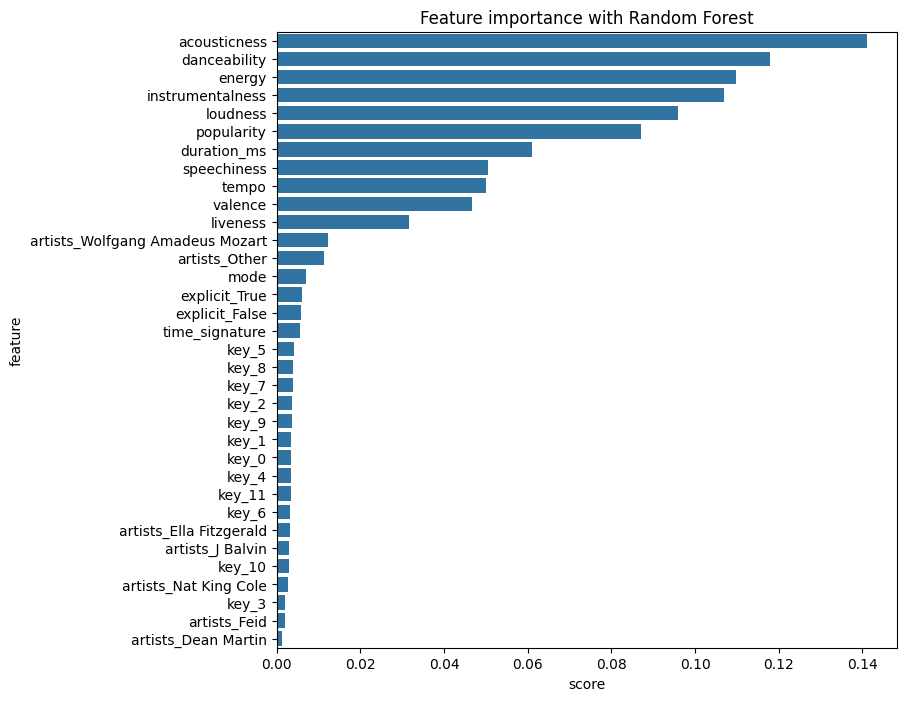

In [7]:
feature_importance_rf = pd.DataFrame({"feature":X_train.columns, "score":rf.feature_importances_})
feature_importance_rf.sort_values(by=["score"], ascending=False, inplace=True)

plt.figure(figsize=(8,8))
sns.barplot(data= feature_importance_rf, x="score", y="feature")
plt.title("Feature importance with Random Forest")
plt.show()

**Disadvantages**: Impurity-based feature importance tend to be strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary or categorical variables. This method can also give a high importance to features used on an overfitted model. These features may not be predictive on unseen data.


# **2. Explainability with SHAP**

**SHAP** (SHapley Additive exPlanations) is a model-agnostic method to explain the predictions of a Machine Learning model. <br> It computes the shapely values of each feature to measure its importance, which is a concept taken from Game Theory.

- In Game theory, shapley values help determine how much each player in a collaborative game has contributed to the total payout (prediction in our case). For a machine learning model, each feature is considered a "player". The Shapley value for a feature represents the **average magnitude of that feature's contribution** across all possible combinations of features.

- SHAP gives the contribution of each feature to the individual predictions (on a sample level). <br> It is thus a **local method for explainability**, even though global importance can be computed by averaging the contributions per feature (an example will be shown later).

<br>

<img src = https://shap.readthedocs.io/en/latest/_images/shap_header.png width = "600" height = "350" >

<br>


SHAP measures the importance of each feature by comparing the predictions made by the model to a **baseline value**. <br> A baseline value is a predicted by a model with no knowledge of any features and is computed by averaging the target values.
- Each shap values represents the difference between the baseline and the predictions
- A negative shap values doesn't mean the feature had no impact on the final prediction

**About SHAP's explainers** <br>
The SHAP package has many types of explainer functions to compute the Shapley values of a given Machine Learning model. <br>
Here are a few important ones:
- `shap.Explainer`: Generic explainer function that can be used on any model (including black-box models such as Neural Networks).
- `shap.TreeExplainer`: Fast explainer that can only be used for tree-based models, such as Decision Trees, Random Forests and Boosting models
- `shap.DeepExplainer`: Explainer designed for deep learning models

You can find the full list of shap explainers [here](https://shap.readthedocs.io/en/latest/api.html).

In [8]:
# !pip install shap --quiet --upgrade

In [9]:
import shap

c:\Users\LaurèneDAVID\OneDrive - IP-PARIS\Data Events\Hickathon 5\Hickathon5\venv_hi5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Compute shap values

Let's use SHAP on our previously trained **Random Forest model** to explain the track genre predictions. <br>
We will use the package's `TreeExplainer` to compute shap values, since our model is tree-based.

For **multiclass classification**, SHAP computes the shap values for each predicted label. In our case, we have six genres to predict. <br> The `shap_values` object contains the computed shap values for every specific genre.

<img src = https://miro.medium.com/v2/resize:fit:1090/1*9LorUdFygbU4vtQRqiO_5g.png width = "550" height = "300" >

In this instance, we are evaluating the importance of each feature in the predictions of the **training set.** <br>
To explain the predictions on the test set, you must compute the model's shap values with `X_test`.




In [10]:
explainer = shap.TreeExplainer(rf)

In [11]:
# Compute the shap values on the training set
np.bool = bool

shap_values = explainer.shap_values(X_train)

# Shap values for the classical genre (index 0)
pd.DataFrame(shap_values[:,:,0], columns=X_train.columns).head()

,popularity,duration_ms,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,key_9,key_10,key_11,artists_Dean Martin,artists_Ella Fitzgerald,artists_Feid,artists_J Balvin,artists_Nat King Cole,artists_Other,artists_Wolfgang Amadeus Mozart
0,-0.014653,-0.005540,-0.022574,-0.018045,-0.026827,-0.000279,-0.002251,-0.035155,-0.019665,0.001985,...,-0.000237,-0.000068,0.001273,0.000256,0.000277,0.000031,0.000037,0.000295,-0.000925,-0.008560
1,-0.005824,-0.024901,0.024411,-0.010206,-0.037720,-0.000394,0.005879,0.041196,-0.082408,-0.001592,...,-0.000310,-0.001133,-0.000460,0.000984,0.001068,0.000087,0.000097,0.001197,0.002554,-0.014298
2,0.024187,0.013023,0.033037,0.120468,0.185841,0.001531,-0.006481,0.198691,0.100440,0.003633,...,-0.000375,0.000747,0.000172,0.002262,0.003597,0.000149,0.000461,0.002498,-0.000021,0.121427
3,0.023251,-0.011257,0.016318,0.141687,0.215512,0.001122,0.018912,0.220140,0.171839,0.002914,...,0.000372,0.000612,0.000217,0.001247,0.002433,0.000195,0.000247,0.002417,0.005969,-0.010512
4,0.015751,-0.008859,-0.025419,-0.030484,-0.036064,-0.000797,-0.002492,-0.041855,-0.019737,-0.000118,...,0.001575,-0.000144,-0.000250,0.000281,0.000346,0.000050,0.000076,0.000418,-0.000817,-0.009458


<u>**Base value**</u>: SHAP measures the importance of each feature by comparing the predictions made by the model to a "baseline value". <br>
A baseline value is a predicted by a model with no knowledge of any features and is computed by averaging the target values.
- Each shap values represents the difference between the baseline and the predictions
- A negative shap values doesn't mean the feature had no impact on the final prediction

## Global feature importance
The computed shap values gives the importance of a feature on a sample level. <br> To get the global feature importance, we need to compute the **average shap values** for each feature across all possible classes.




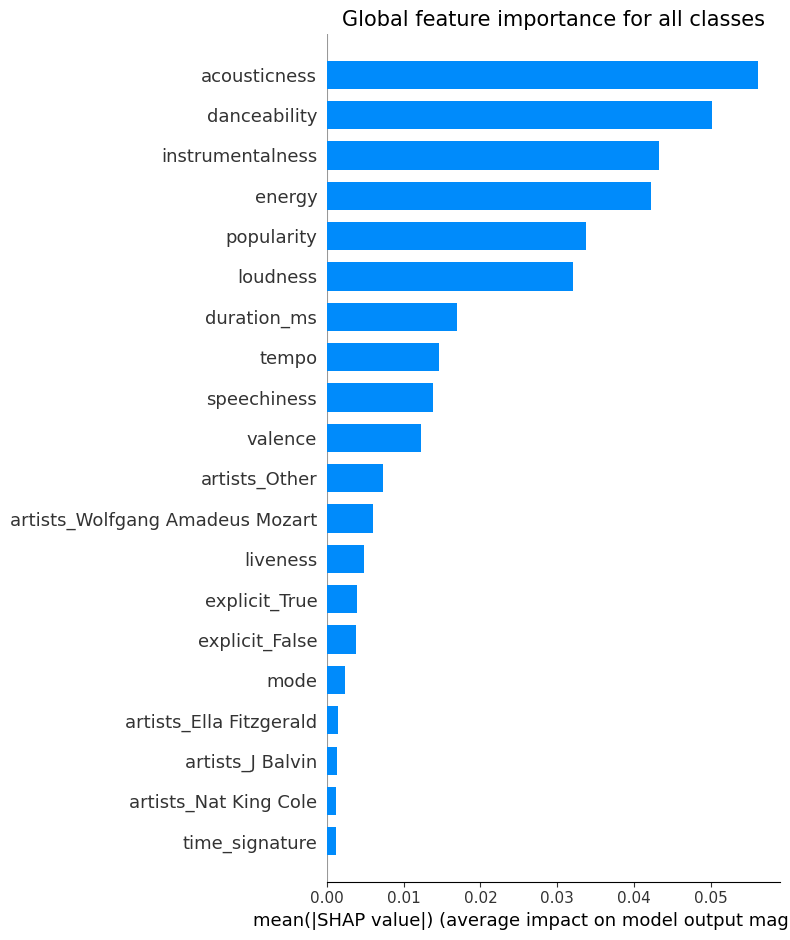

In [12]:
# Average SHAP values across classes (for multi-class classification)
shap_values_mean = np.abs(shap_values).mean(axis=2)

# Plot global feature importance for all classes
plt.title("Global feature importance for all classes", fontsize=15)
shap.summary_plot(shap_values_mean, X_train, feature_names=X_train.columns, plot_type="bar")

We can also look at the feature importance for each individual class.

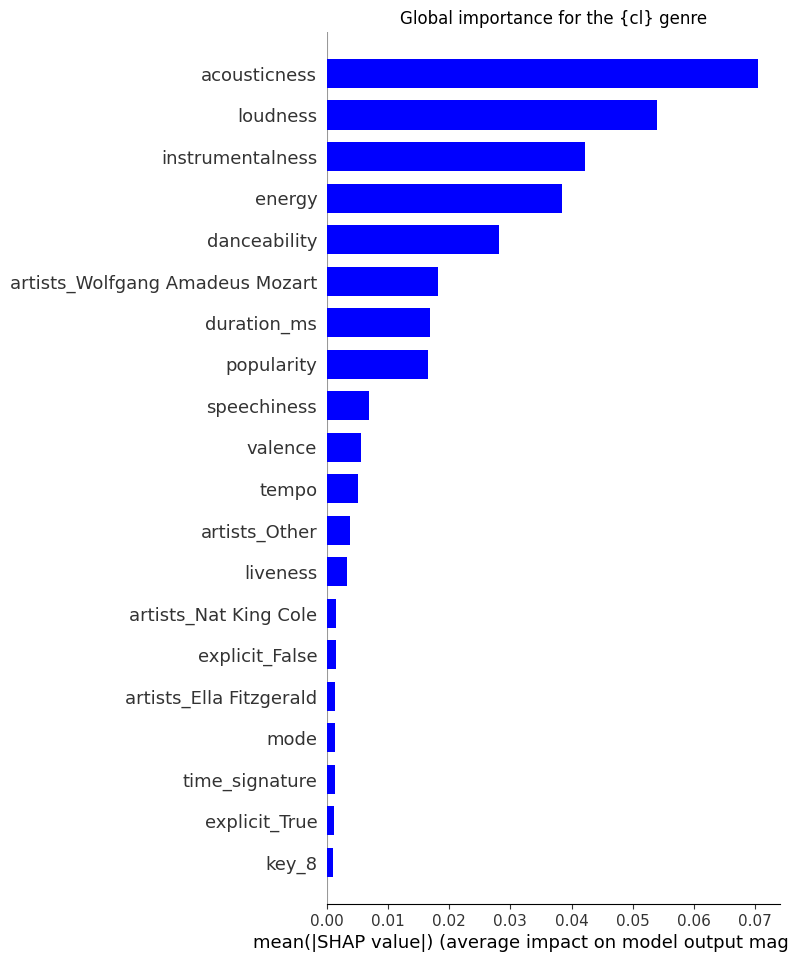

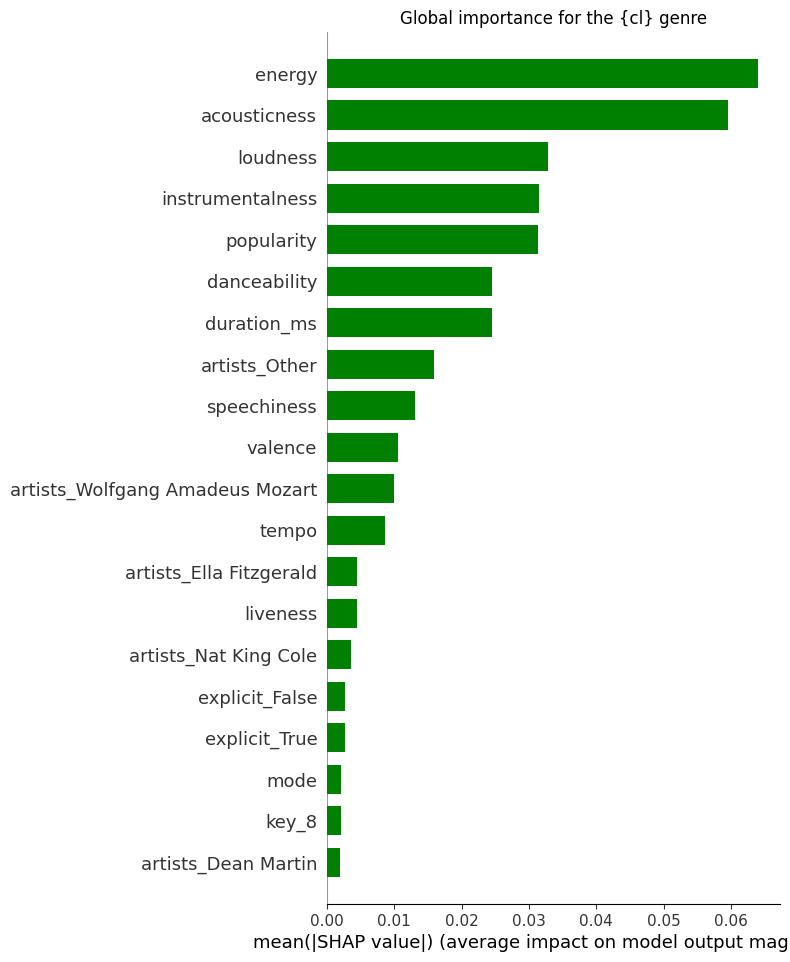

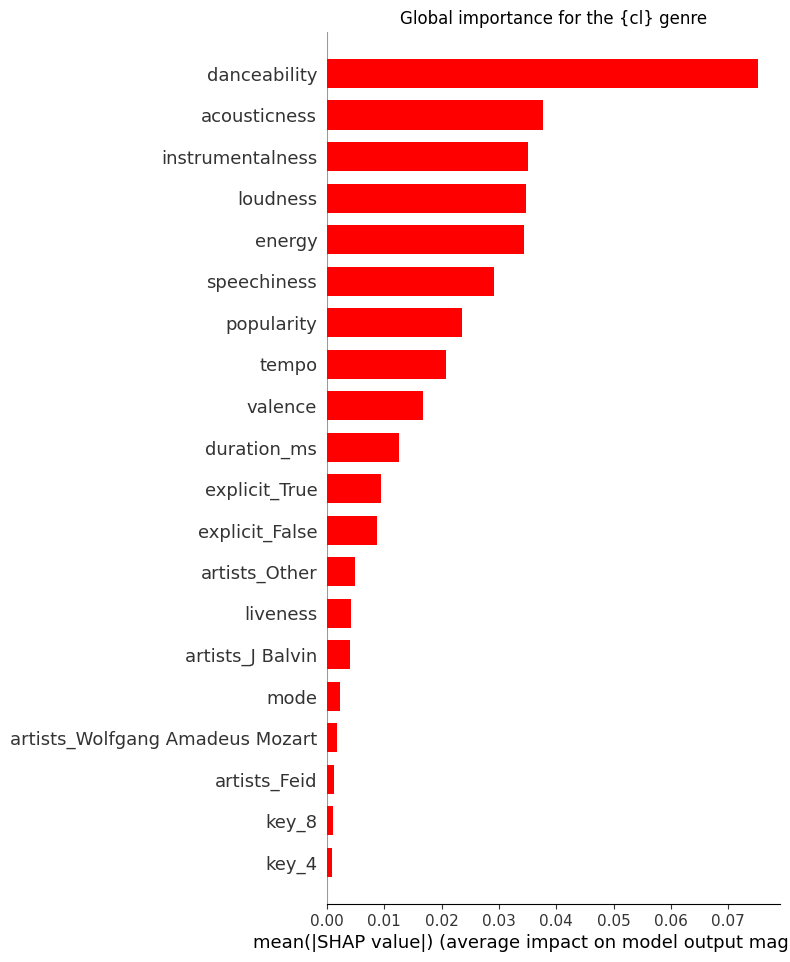

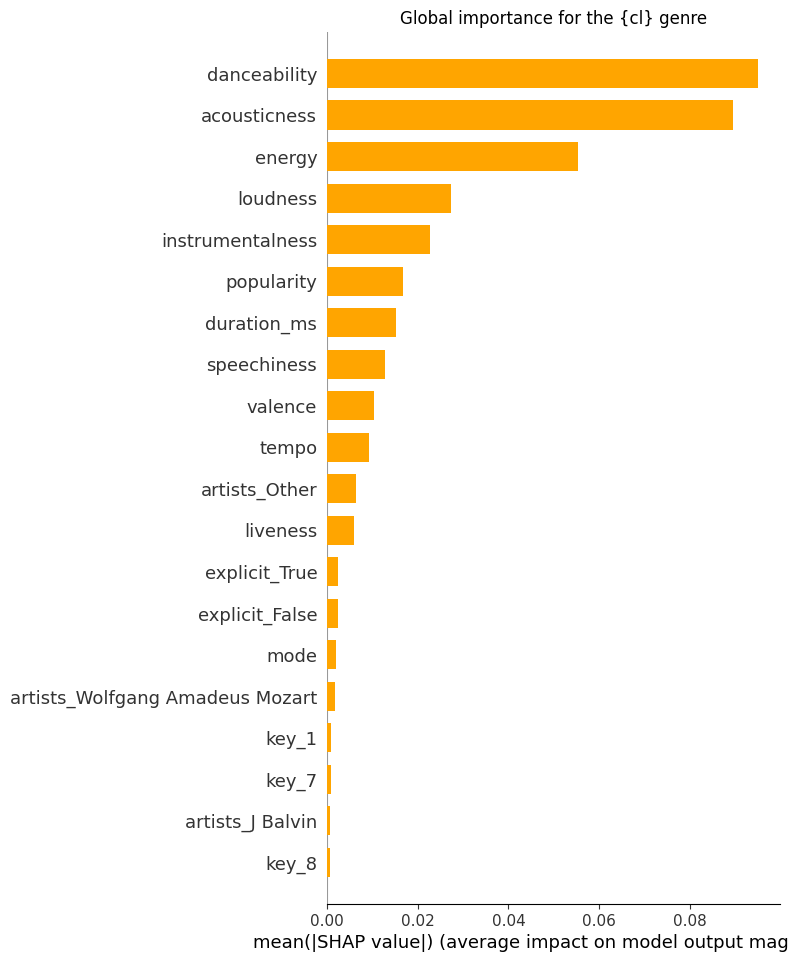

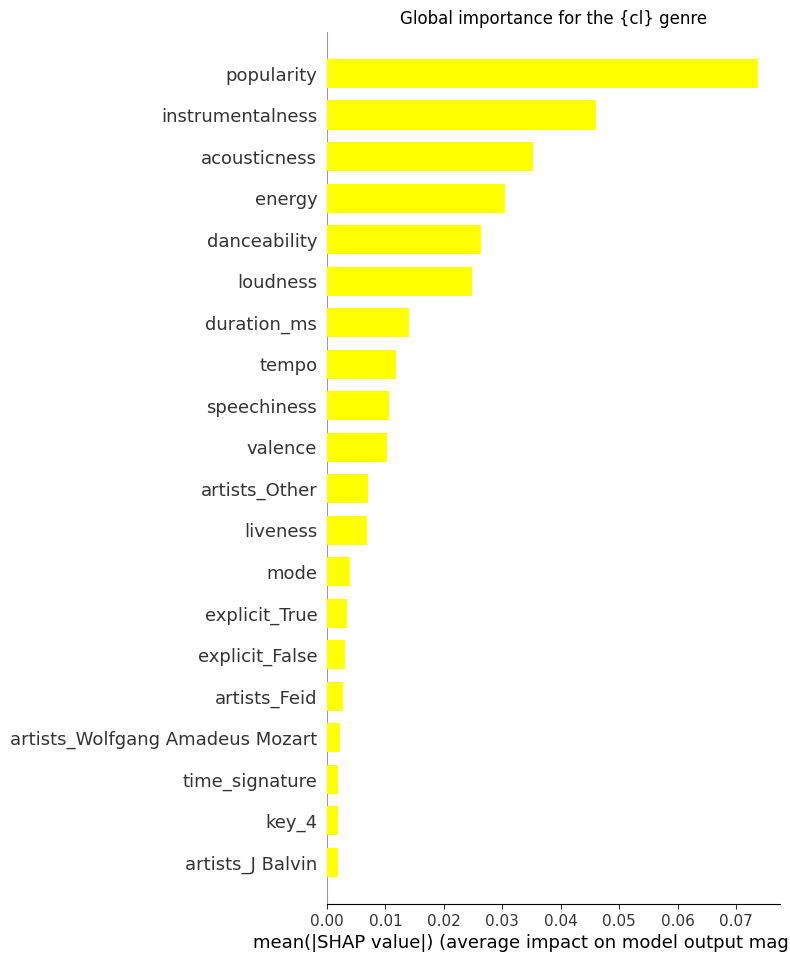

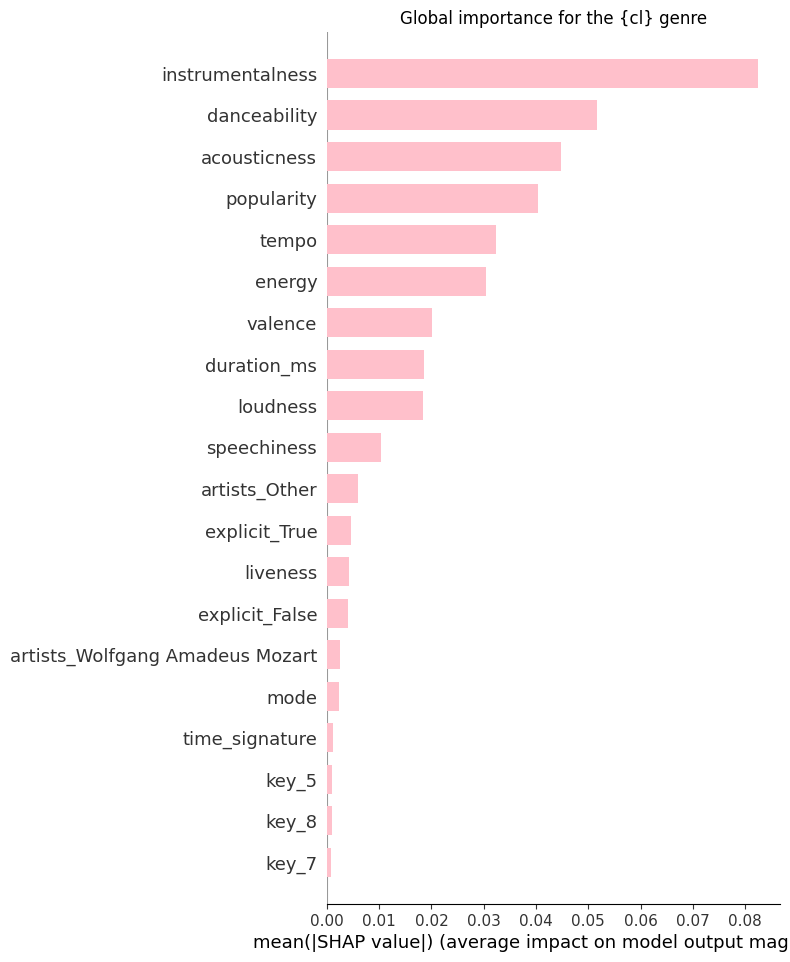

In [16]:
colors = ["blue", "green", "red", "orange", "yellow", "pink"]

for idx, cl in enumerate(rf.classes_):
    shap.summary_plot(shap_values[:,:,idx], X_train, feature_names=X_train.columns, plot_type="bar", color=colors[idx], show=False)
    plt.title("Global importance for the {cl} genre")
    plt.show()

## Local feature importance
To understand how a feature impacted the final predictions, we will use `.summary_plot()` with `plot_type="dot"`. <br>
In the following example, we will explain the predictions for only the <u>classical</u> case since shap doesn't allow multiclass output with this type of plot.

The following graph shows the **impact (positive or negative) of a feature for a single predicted point**.

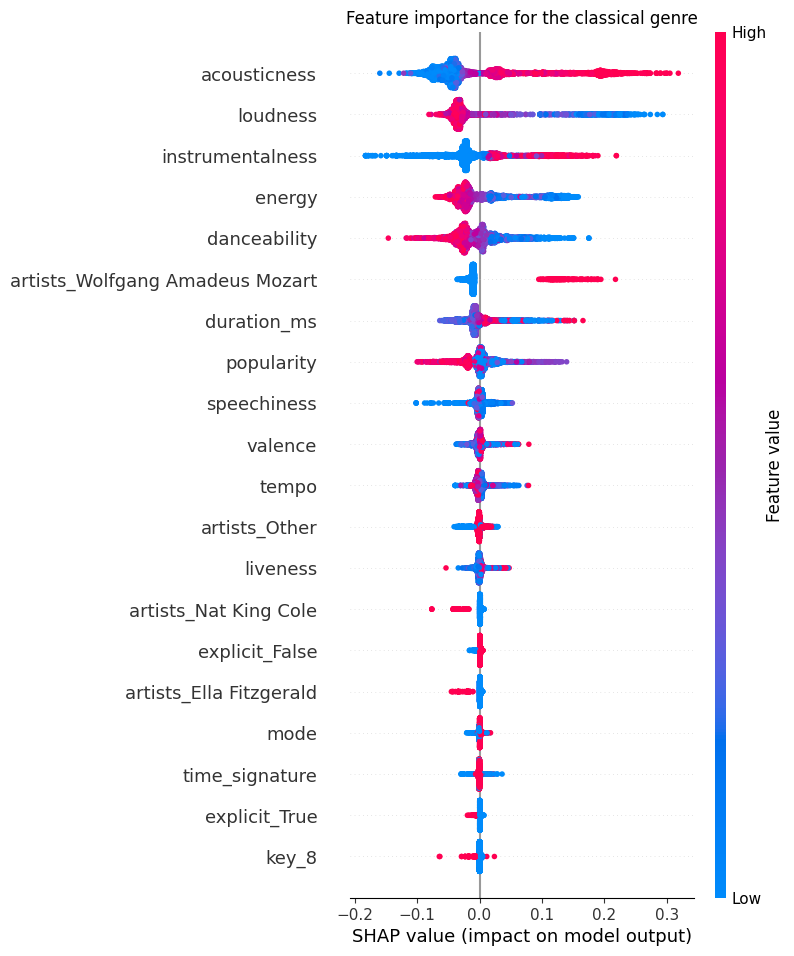

In [17]:
shap.summary_plot(shap_values[:,:,0], X_train, feature_names=X_train.columns, plot_type="dot", show=False) # show=False to be able to add title
plt.title("Feature importance for the classical genre")
plt.show()

In this graph, the x-axis represents the shap value, and the y-axis represents the features. 
- Each point on the chart is a single value for a prediction and feature. 
- Red color means higher value of a feature. 
- Blue means lower value of a feature.


**How to interpret this graph ?** <br>
- Songs with a higher acousticness level are more likely to be classified as "classical" by the model
- Songs with a higher loudness value tend to be classified more often as "classical"

# **3. Explainability with Permutation Importance and Partial Dependance plot**

SHAP can be difficult to use on large datasets since the computation of shap values can be very slow. <br>
In this section, we will show you two "faster" model-agnostic methods to compute feature importance using `sklearn`.



## Permutation Importance

**Permutation feature importance** computes its score by measuring the decrease in a model's performance when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

<br>

<img src = https://www.aporia.com/wp-content/webp-express/webp-images/uploads/2022/09/Untitled-1100-%C3%97-650-px-1024x605.png.webp width = "600" height = "350" >

<u> Note </u>: Features that are deemed of low importance for a bad model could be very important for a good model. Permutation importance does not reflect to the importance of a feature by itself but how important this feature is for a particular model.



In [18]:
from sklearn.inspection import permutation_importance

# Compute permutation importance for each feature using an accuracy score
permutation_score = permutation_importance(rf, X_train, y_train, n_repeats=30, scoring="accuracy", random_state=0) # n_repeats: number of times data is reshuffled

# Create dataframe
permutation_df = pd.DataFrame({"feature":X_train.columns,
                               "mean score":permutation_score.importances_mean,
                               "std":permutation_score.importances_std})

In [19]:
permutation_df.sort_values(by=["mean score"], ascending=False, inplace=True)
permutation_df.head()

,feature,mean score,std
2,danceability,0.125797,0.003862
0,popularity,0.079519,0.003036
7,acousticness,0.078098,0.003616
8,instrumentalness,0.074003,0.003791
3,energy,0.027526,0.001999


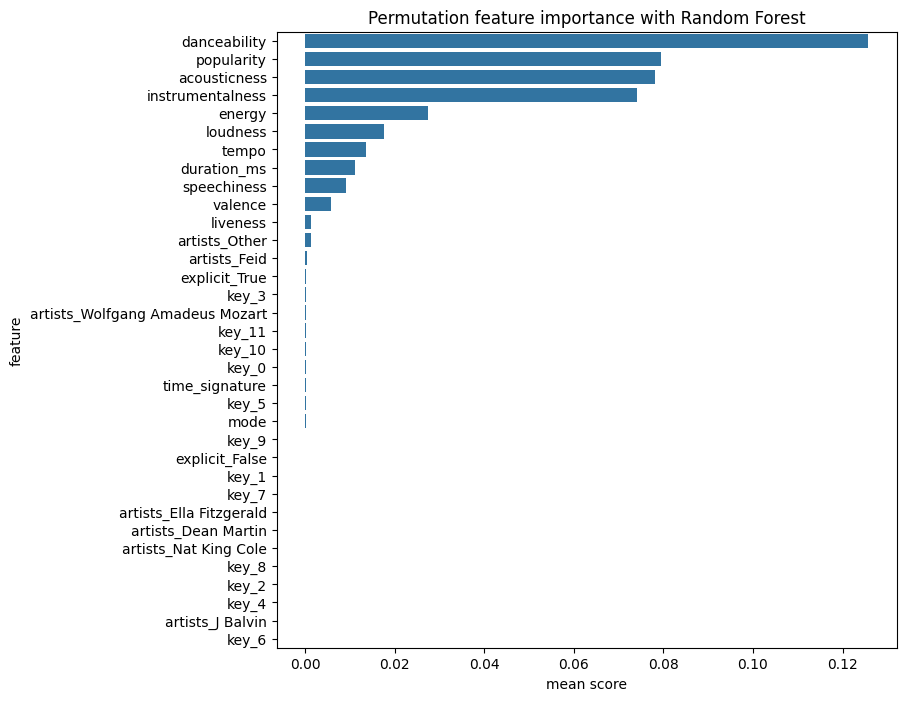

In [20]:
plt.figure(figsize=(8,8))
sns.barplot(data = permutation_df, x="mean score", y="feature")
plt.title("Permutation feature importance with Random Forest")
plt.show()

## Partial Dependance plot

**Partial dependence plots** shows the relationship between a feature and the predictions of a model while keeping other features constant. It can show whether the relationship between the target and a feature is linear, monotonic or more complex.
- It is a useful tool for interpreting the effects of individual features on the model's predictions without having use the `shap` package.
- These plots can only be used to explain the impact of one to two features, so it can be useful to first select which features to study using other explainability methods.

**How is partial dependence computed ?**
- Start by creating multiple versions of the chosen feature with different values
- Duplicate the training dataset by only modifying the values of the chosen feature
- Train a Machine Learning model on each duplicate datasets then aggregate the target value for each
- Plot the aggregated target value based on the value of the chosen feature

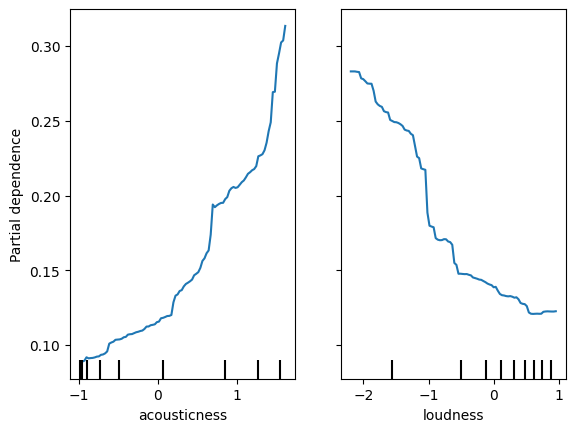

In [21]:
from sklearn.inspection import PartialDependenceDisplay

selected_features = ["acousticness", "loudness"]
PartialDependenceDisplay.from_estimator(rf, X_train, features=selected_features, target="classical")
plt.show()

**How to interpret this graph ?**
- A higher acousticness level tends to increase the target value (the target gets closer to 1, which is when the track's genre is classical)
- A lower danceability level tends to decrease the target value (the target gets closer to 0, which is when the track's genre is not classical)

You can also create a partial dependance plot using two features. <br>
It can show the impact of a combination of these features on the final predictions.

**Note**: Using two features to create a partial dependance plot can be computationally expensive.

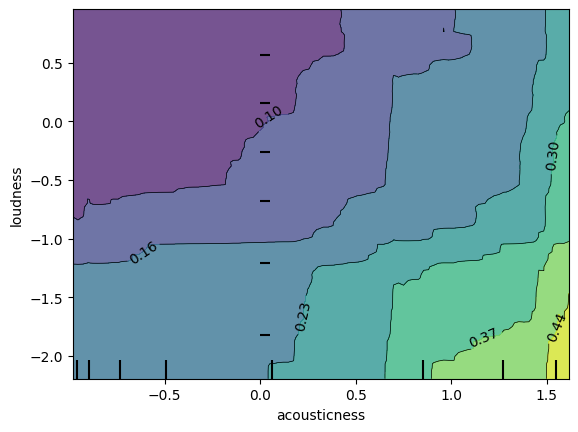

In [22]:
selected_features = [("acousticness", "loudness")]
PartialDependenceDisplay.from_estimator(rf, X_train, features=selected_features, target="classical")
plt.show()

**How to interpret this graph ?** <br>
Songs with a higher acousticness level and a lower loudness level were more often predicted as classical by the model.
- `Acousticness` has a "positive" impact on predictions (increases the chance of being predicted 1)
- `Loudness` has a "negative" impact on predictions (decreases the change of being predicted 0)


# **4. Other packages/frameworks**

Many python packages/frameworks exist to compute model explainability. <br>
Here are few you can also check out:
- **Shapash**: Python library based on SHAP, designed to build user-friendly interactive dashboards for machine learning model explainability. (https://shapash.readthedocs.io/en/latest/)
- **LIME** (Local Interpretable Model-agnostic Explanations): Explain individual predictions by fitting simple interpretable models (e.g., linear models) locally around the prediction (https://github.com/marcotcr/lime?tab=readme-ov-file)
- **Captum**: PyTorch library for Deep Learning model explainability. It offers gradient-based attribution methods like Integrated Gradients, Saliency Maps, and DeepLIFT.
- **TF-Explain**: A TensorFlow-based library providing tools for visualizing Grad-CAM, Saliency Maps, and other interpretability techniques for neural networks.

<br>

**Example of a Shapash app**

<img src =
https://miro.medium.com/v2/resize:fit:720/format:webp/1*oaJTad5H3PZk5oUNrcoXag.gif width = "800" height = "450" >

<br>

**Example of Grad-CAM explainability on images**

<img src=https://datascientest.com/en/files/2021/07/Original-Image.jpg width = "500" height="250">

The Hi! PARIS Engineering Team also developed a package for AI Explainability called **XPER**. <br>
You can check it out here: https://github.com/hi-paris/XPER/.

<font size='5'>**The Explainability course ends here, thank you for listening !** </font><br>
This notebook is available on HFactory and Github.